# RAMP on predicting 2022 French presidential elections

## Introduction

The different data sets used in this project are all freely accessible through either the French Government open data platform or INSEE website. To get more details on how to download it, check the README file. <br>
The main dataset contains for each candidate, for each city and for each polling station the scores of each candidate at the first round of the 2022 French Presidential Elections. <br>
Additionnaly to this data, we also collected the latest INSEE datasets on employement statistics and the income statistics, as well as 2017 elections results. Both INSEE datasets come with a documentation file : they can be found in the data/documentation folder or online (check read me for more details)

For practical reasons, the challenge focuses only on French Departments (mainland and overseas). Territories such as Mayotte or overseas polling stations are excluded for practical reasons (missing data, no financial data, etc...).

The goal is to predict the score of each candidate for each french city. The prediction quality is measured with the RMSE.

Users are not restricted to the data provided with this challenge and we encourage looking for other potential datasets.

In [47]:
%matplotlib inline
import os
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the dataset using pandas

The training and testing sets are located in the folder data. They can be loaded with pandas

In [51]:
from problem import get_train_data

data_train, labels_train = get_train_data()

In [52]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68593 entries, 659171 to 75416
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Code du département            68593 non-null  object
 1   Libellé du département         68593 non-null  object
 2   Code de la circonscription     68593 non-null  int64 
 3   Libellé de la circonscription  68593 non-null  object
 4   Code de la commune             68593 non-null  object
 5   Libellé de la commune          68593 non-null  object
 6   Code du b.vote                 68593 non-null  object
 7   Inscrits                       68593 non-null  int64 
 8   Votants                        68593 non-null  int64 
 9   location                       65585 non-null  object
dtypes: int64(3), object(7)
memory usage: 5.8+ MB


We can see some missing values for location. we should take a first look and see how big this polling stations are

In [53]:
data_train[data_train['location'].isnull()].drop_duplicates(['Code de la commune']).agg({"Inscrits":[np.mean, np.median,np.sum,'count']}).round(0)

,Inscrits
mean,467.0
median,332.0
sum,299144.0
count,641.0


Small villages tend to be overwhelmingly represented within the cities wissing missing values. To fill them, we will compute the baryton for each department, and use this values with a small random noise to fill it

We first need to add the the latitude & longitude

In [54]:
from problem import get_latitude_longitude, correct_missing_locations

data_train = get_latitude_longitude(data_train)

Once we have them, we compute the barycenter of each department and we add some noise to it for each city with missing location. The final locations might end up in the wrong department (they are not circles), but it should be good enough approximations.

In [55]:
data_train = correct_missing_locations(data_train)

In [56]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68593 entries, 659171 to 75416
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Code du département            68593 non-null  object 
 1   Libellé du département         68593 non-null  object 
 2   Code de la circonscription     68593 non-null  int64  
 3   Libellé de la circonscription  68593 non-null  object 
 4   Code de la commune             68593 non-null  object 
 5   Libellé de la commune          68593 non-null  object 
 6   Code du b.vote                 68593 non-null  object 
 7   Inscrits                       68593 non-null  int64  
 8   Votants                        68593 non-null  int64  
 9   longitude                      67693 non-null  float64
 10  latitude                       67693 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 6.3+ MB


Now that we have cleaned the data, we should look a bit at our targets.

Text(0.5, 1.0, 'maximum number votes = 1907')

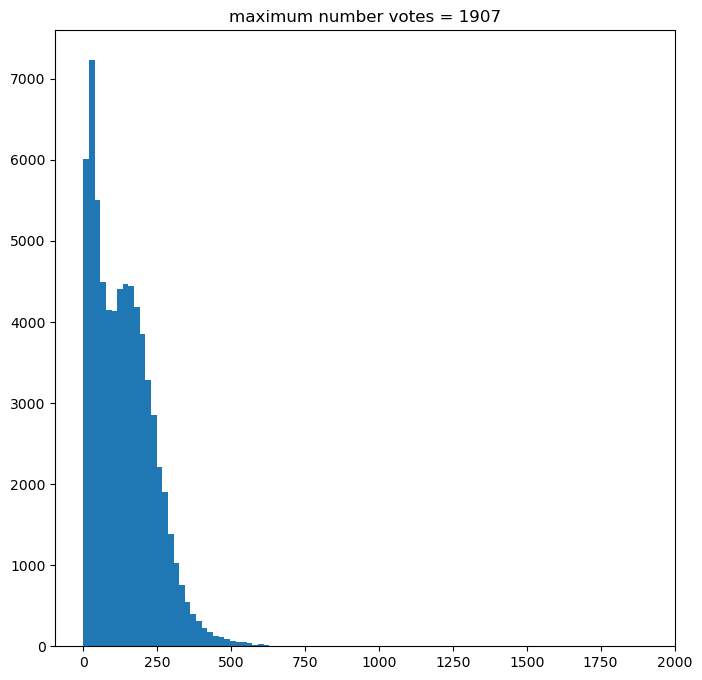

In [60]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.hist(labels_train,bins=100)
ax.set_title(f'maximum number votes = {labels_train.max()}')

As one can notice, we have a very skewed distribution

Text(0.5, 1.0, 'maximum number votes = 1907')

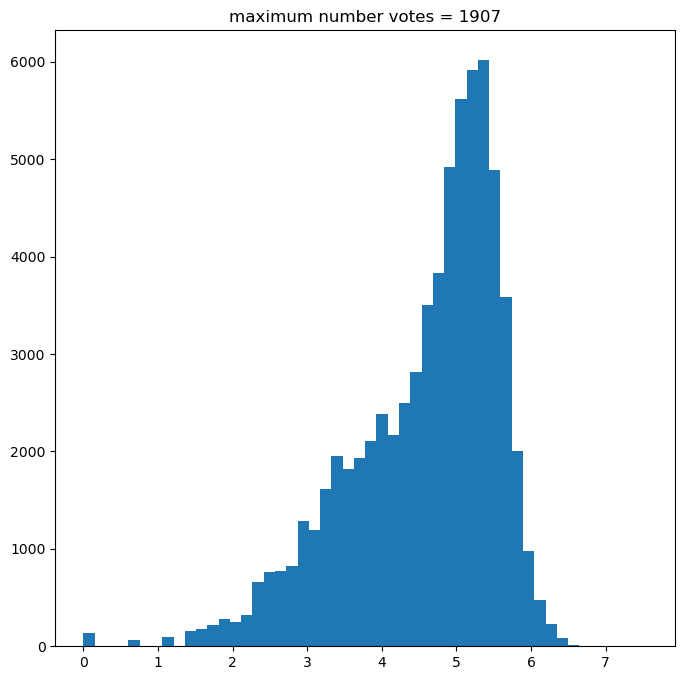

In [63]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.hist(np.log(labels_train+1),bins=50)
ax.set_title(f'maximum number votes = {labels_train.max()}')

We get a distribution which is much more "Gaussian"-Like : Our target will be the Log-Vote value rather than the simple number of votes.